In [34]:
import pandas as pd
import duckdb 
import seaborn as sns
import glob
import tqdm
sys.path.append("/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/")
from scripts import initial_map, map_refiner, complexity, finder, preprocess, error_correct, plotting, umi_deduplicate, pipelines
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
! mv /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/NKX2-2_CC_UMI_whitelisted_concat_custom_threshold_redone.db /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/puro_only_NKX2-2_CC_UMI_whitelisted_concat_custom_threshold_redone.db

# 1. Puro

In [2]:
db_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/puro_only_NKX2-2_CC_UMI_whitelisted_concat_custom_threshold_redone.db"
db_path

'/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/NKX2-2_CC_UMI_whitelisted_concat_custom_threshold_redone.db'

In [3]:
AD_seq_files = glob.glob(
    "/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/a*fastq"
)
AD_seq_files

['/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/a16_ADBC_Puro_Only_R4_T48_S88.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/a15_ADBC_Puro_Only_R3_T48_S93.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/a5_ADBC_Puro_Only_R1_T4_S94.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/a11_ADBC_Puro_Only_R3_T24_S100.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/a12_ADBC_Puro_Only_R4_T24_S101.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/a19_ADBC_Puro_Only_R3_T0_S91.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/a10_ADBC_Puro_Only_R2_T24_S99.assembled.fastq',
 '/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/TL4B2/puro_only/a6_ADBC_Puro_Only_R2_T4_S95.assembled.fastq',
 '/global/scratch/projects/

In [4]:
con = duckdb.connect(database=db_path, read_only=False)

# Example: list tables
tables = con.execute("SHOW TABLES").fetchall()
for table in tables:
    if "initial" in table:
        print(table)

In [5]:
tables[:10]

[('barcode_map',),
 ('umi_a10_ADBC_Puro_Only_R2_T24_S99_ADBC2_HawkBCs_error_corrected',),
 ('umi_a10_ADBC_Puro_Only_R2_T24_S99_ADBC2_HawkBCs_error_corrected_umis_collapsed',),
 ('umi_a10_ADBC_Puro_Only_R2_T24_S99_ADBC2_HawkBCs_initial',),
 ('umi_a10_ADBC_Puro_Only_R2_T24_S99_ADBC2_HawkBCs_loss_summary',),
 ('umi_a10_ADBC_Puro_Only_R2_T24_S99_ADBC2_HawkBCs_quality',),
 ('umi_a10_ADBC_Puro_Only_R2_T24_S99_ADBC2_HawkBCs_unique_barcodes',),
 ('umi_a11_ADBC_Puro_Only_R3_T24_S100_ADBC2_HawkBCs_error_corrected',),
 ('umi_a11_ADBC_Puro_Only_R3_T24_S100_ADBC2_HawkBCs_error_corrected_umis_collapsed',),
 ('umi_a11_ADBC_Puro_Only_R3_T24_S100_ADBC2_HawkBCs_initial',)]

In [6]:
# Get all tables
tables = con.execute("SHOW TABLES").fetchall()
tables = [t[0] for t in tables]  # flatten list of tuples

# Filter tables ending with '_initial'
initial_tables = [t for t in tables if t.endswith('_initial')]
initial_tables

['umi_a10_ADBC_Puro_Only_R2_T24_S99_ADBC2_HawkBCs_initial',
 'umi_a11_ADBC_Puro_Only_R3_T24_S100_ADBC2_HawkBCs_initial',
 'umi_a12_ADBC_Puro_Only_R4_T24_S101_ADBC2_HawkBCs_initial',
 'umi_a13_ADBC_Puro_Only_R1_T48_S86_ADBC2_HawkBCs_initial',
 'umi_a14_ADBC_Puro_Only_R2_T48_S87_ADBC2_HawkBCs_initial',
 'umi_a15_ADBC_Puro_Only_R3_T48_S93_ADBC2_HawkBCs_initial',
 'umi_a16_ADBC_Puro_Only_R4_T48_S88_ADBC2_HawkBCs_initial',
 'umi_a17_ADBC_Puro_Only_R1_T0_S89_ADBC2_HawkBCs_initial',
 'umi_a18_ADBC_Puro_Only_R2_T0_S90_ADBC2_HawkBCs_initial',
 'umi_a19_ADBC_Puro_Only_R3_T0_S91_ADBC2_HawkBCs_initial',
 'umi_a20_ADBC_Puro_Only_R4_T0_S92_ADBC2_HawkBCs_initial',
 'umi_a5_ADBC_Puro_Only_R1_T4_S94_ADBC2_HawkBCs_initial',
 'umi_a6_ADBC_Puro_Only_R2_T4_S95_ADBC2_HawkBCs_initial',
 'umi_a7_ADBC_Puro_Only_R3_T4_S96_ADBC2_HawkBCs_initial',
 'umi_a8_ADBC_Puro_Only_R4_T4_S97_ADBC2_HawkBCs_initial',
 'umi_a9_ADBC_Puro_Only_R1_T24_S98_ADBC2_HawkBCs_initial',
 'umi_r10_RTBC_Puro_Only_R2_T24_S107_RTBC_initial',

In [13]:
# Loop through each _initial table
for table in tqdm.tqdm(initial_tables):
    # Get column names
    cols = con.execute(f"PRAGMA table_info({table})").fetchall()
    col_names = [c[1] for c in cols if "UMI" not in c[1]]  # exclude columns with "UMI"
    
    # Skip tables that have no columns left after filtering
    if not col_names:
        print(f"Skipping {table}: no columns left after removing UMI columns")
        continue

    # New table name: replace '_initial' with '_grouped'
    new_table = table.replace("_initial", "_grouped")
    
    # SQL to create the grouped table
    sql = f"""
        CREATE OR REPLACE TABLE {new_table} AS
        SELECT {', '.join(col_names)}, COUNT(*) AS count
        FROM {table}
        GROUP BY {', '.join(col_names)}
        ORDER BY count DESC
    """
    
    # Execute
    con.execute(sql)
    print(f"Saved grouped table: {new_table}")

  6%|▋         | 2/32 [00:00<00:01, 18.06it/s]

Saved grouped table: umi_a10_ADBC_Puro_Only_R2_T24_S99_ADBC2_HawkBCs_grouped
Saved grouped table: umi_a11_ADBC_Puro_Only_R3_T24_S100_ADBC2_HawkBCs_grouped
Saved grouped table: umi_a12_ADBC_Puro_Only_R4_T24_S101_ADBC2_HawkBCs_grouped
Saved grouped table: umi_a13_ADBC_Puro_Only_R1_T48_S86_ADBC2_HawkBCs_grouped


 22%|██▏       | 7/32 [00:00<00:01, 15.32it/s]

Saved grouped table: umi_a14_ADBC_Puro_Only_R2_T48_S87_ADBC2_HawkBCs_grouped
Saved grouped table: umi_a15_ADBC_Puro_Only_R3_T48_S93_ADBC2_HawkBCs_grouped
Saved grouped table: umi_a16_ADBC_Puro_Only_R4_T48_S88_ADBC2_HawkBCs_grouped
Saved grouped table: umi_a17_ADBC_Puro_Only_R1_T0_S89_ADBC2_HawkBCs_grouped


 47%|████▋     | 15/32 [00:00<00:00, 24.92it/s]

Saved grouped table: umi_a18_ADBC_Puro_Only_R2_T0_S90_ADBC2_HawkBCs_grouped
Saved grouped table: umi_a19_ADBC_Puro_Only_R3_T0_S91_ADBC2_HawkBCs_grouped
Saved grouped table: umi_a20_ADBC_Puro_Only_R4_T0_S92_ADBC2_HawkBCs_grouped
Saved grouped table: umi_a5_ADBC_Puro_Only_R1_T4_S94_ADBC2_HawkBCs_grouped
Saved grouped table: umi_a6_ADBC_Puro_Only_R2_T4_S95_ADBC2_HawkBCs_grouped
Saved grouped table: umi_a7_ADBC_Puro_Only_R3_T4_S96_ADBC2_HawkBCs_grouped
Saved grouped table: umi_a8_ADBC_Puro_Only_R4_T4_S97_ADBC2_HawkBCs_grouped
Saved grouped table: umi_a9_ADBC_Puro_Only_R1_T24_S98_ADBC2_HawkBCs_grouped
Saved grouped table: umi_r10_RTBC_Puro_Only_R2_T24_S107_RTBC_grouped


 56%|█████▋    | 18/32 [00:01<00:02,  6.72it/s]

Saved grouped table: umi_r11_RTBC_Puro_Only_R3_T24_S108_RTBC_grouped
Saved grouped table: umi_r12_RTBC_Puro_Only_R4_T24_S109_RTBC_grouped


 69%|██████▉   | 22/32 [00:02<00:01,  7.47it/s]

Saved grouped table: umi_r13_RTBC_Puro_Only_R1_T48_S110_RTBC_grouped
Saved grouped table: umi_r14_RTBC_Puro_Only_R2_T48_S111_RTBC_grouped
Saved grouped table: umi_r15_RTBC_Puro_Only_R3_T48_S112_RTBC_grouped


 91%|█████████ | 29/32 [00:03<00:00,  8.20it/s]

Saved grouped table: umi_r16_RTBC_Puro_Only_R4_T48_S113_RTBC_grouped
Saved grouped table: umi_r17_RTBC_Puro_Only_R1_T0_S114_RTBC_grouped
Saved grouped table: umi_r18_RTBC_Puro_Only_R2_T0_S115_RTBC_grouped
Saved grouped table: umi_r19_RTBC_Puro_Only_R3_T0_S116_RTBC_grouped
Saved grouped table: umi_r20_RTBC_Puro_Only_R4_T0_S117_RTBC_grouped
Saved grouped table: umi_r5_RTBC_Puro_Only_R1_T4_S102_RTBC_grouped
Saved grouped table: umi_r6_RTBC_Puro_Only_R2_T4_S103_RTBC_grouped


100%|██████████| 32/32 [00:03<00:00,  9.28it/s]

Saved grouped table: umi_r7_RTBC_Puro_Only_R3_T4_S104_RTBC_grouped
Saved grouped table: umi_r8_RTBC_Puro_Only_R4_T4_S105_RTBC_grouped
Saved grouped table: umi_r9_RTBC_Puro_Only_R1_T24_S106_RTBC_grouped


In [14]:
tables = con.execute("SHOW TABLES").fetchall()
tables = [t[0] for t in tables]  # flatten list of tuples

grouped_tables = [t for t in tables if t.endswith('_grouped')]
grouped_tables

['umi_a10_ADBC_Puro_Only_R2_T24_S99_ADBC2_HawkBCs_grouped',
 'umi_a11_ADBC_Puro_Only_R3_T24_S100_ADBC2_HawkBCs_grouped',
 'umi_a12_ADBC_Puro_Only_R4_T24_S101_ADBC2_HawkBCs_grouped',
 'umi_a13_ADBC_Puro_Only_R1_T48_S86_ADBC2_HawkBCs_grouped',
 'umi_a14_ADBC_Puro_Only_R2_T48_S87_ADBC2_HawkBCs_grouped',
 'umi_a15_ADBC_Puro_Only_R3_T48_S93_ADBC2_HawkBCs_grouped',
 'umi_a16_ADBC_Puro_Only_R4_T48_S88_ADBC2_HawkBCs_grouped',
 'umi_a17_ADBC_Puro_Only_R1_T0_S89_ADBC2_HawkBCs_grouped',
 'umi_a18_ADBC_Puro_Only_R2_T0_S90_ADBC2_HawkBCs_grouped',
 'umi_a19_ADBC_Puro_Only_R3_T0_S91_ADBC2_HawkBCs_grouped',
 'umi_a20_ADBC_Puro_Only_R4_T0_S92_ADBC2_HawkBCs_grouped',
 'umi_a5_ADBC_Puro_Only_R1_T4_S94_ADBC2_HawkBCs_grouped',
 'umi_a6_ADBC_Puro_Only_R2_T4_S95_ADBC2_HawkBCs_grouped',
 'umi_a7_ADBC_Puro_Only_R3_T4_S96_ADBC2_HawkBCs_grouped',
 'umi_a8_ADBC_Puro_Only_R4_T4_S97_ADBC2_HawkBCs_grouped',
 'umi_a9_ADBC_Puro_Only_R1_T24_S98_ADBC2_HawkBCs_grouped',
 'umi_r10_RTBC_Puro_Only_R2_T24_S107_RTBC_grouped',

In [21]:
import re

In [25]:
re.search("h", "hi")

<re.Match object; span=(0, 1), match='h'>

In [31]:
grouped_ADBC_tables = [g for g in grouped_tables if "ADBC" in g]
grouped_ADBC_tables

['umi_a10_ADBC_Puro_Only_R2_T24_S99_ADBC2_HawkBCs_grouped',
 'umi_a11_ADBC_Puro_Only_R3_T24_S100_ADBC2_HawkBCs_grouped',
 'umi_a12_ADBC_Puro_Only_R4_T24_S101_ADBC2_HawkBCs_grouped',
 'umi_a13_ADBC_Puro_Only_R1_T48_S86_ADBC2_HawkBCs_grouped',
 'umi_a14_ADBC_Puro_Only_R2_T48_S87_ADBC2_HawkBCs_grouped',
 'umi_a15_ADBC_Puro_Only_R3_T48_S93_ADBC2_HawkBCs_grouped',
 'umi_a16_ADBC_Puro_Only_R4_T48_S88_ADBC2_HawkBCs_grouped',
 'umi_a17_ADBC_Puro_Only_R1_T0_S89_ADBC2_HawkBCs_grouped',
 'umi_a18_ADBC_Puro_Only_R2_T0_S90_ADBC2_HawkBCs_grouped',
 'umi_a19_ADBC_Puro_Only_R3_T0_S91_ADBC2_HawkBCs_grouped',
 'umi_a20_ADBC_Puro_Only_R4_T0_S92_ADBC2_HawkBCs_grouped',
 'umi_a5_ADBC_Puro_Only_R1_T4_S94_ADBC2_HawkBCs_grouped',
 'umi_a6_ADBC_Puro_Only_R2_T4_S95_ADBC2_HawkBCs_grouped',
 'umi_a7_ADBC_Puro_Only_R3_T4_S96_ADBC2_HawkBCs_grouped',
 'umi_a8_ADBC_Puro_Only_R4_T4_S97_ADBC2_HawkBCs_grouped',
 'umi_a9_ADBC_Puro_Only_R1_T24_S98_ADBC2_HawkBCs_grouped']

Text(0.5, 0.95, 'Puro_Only')

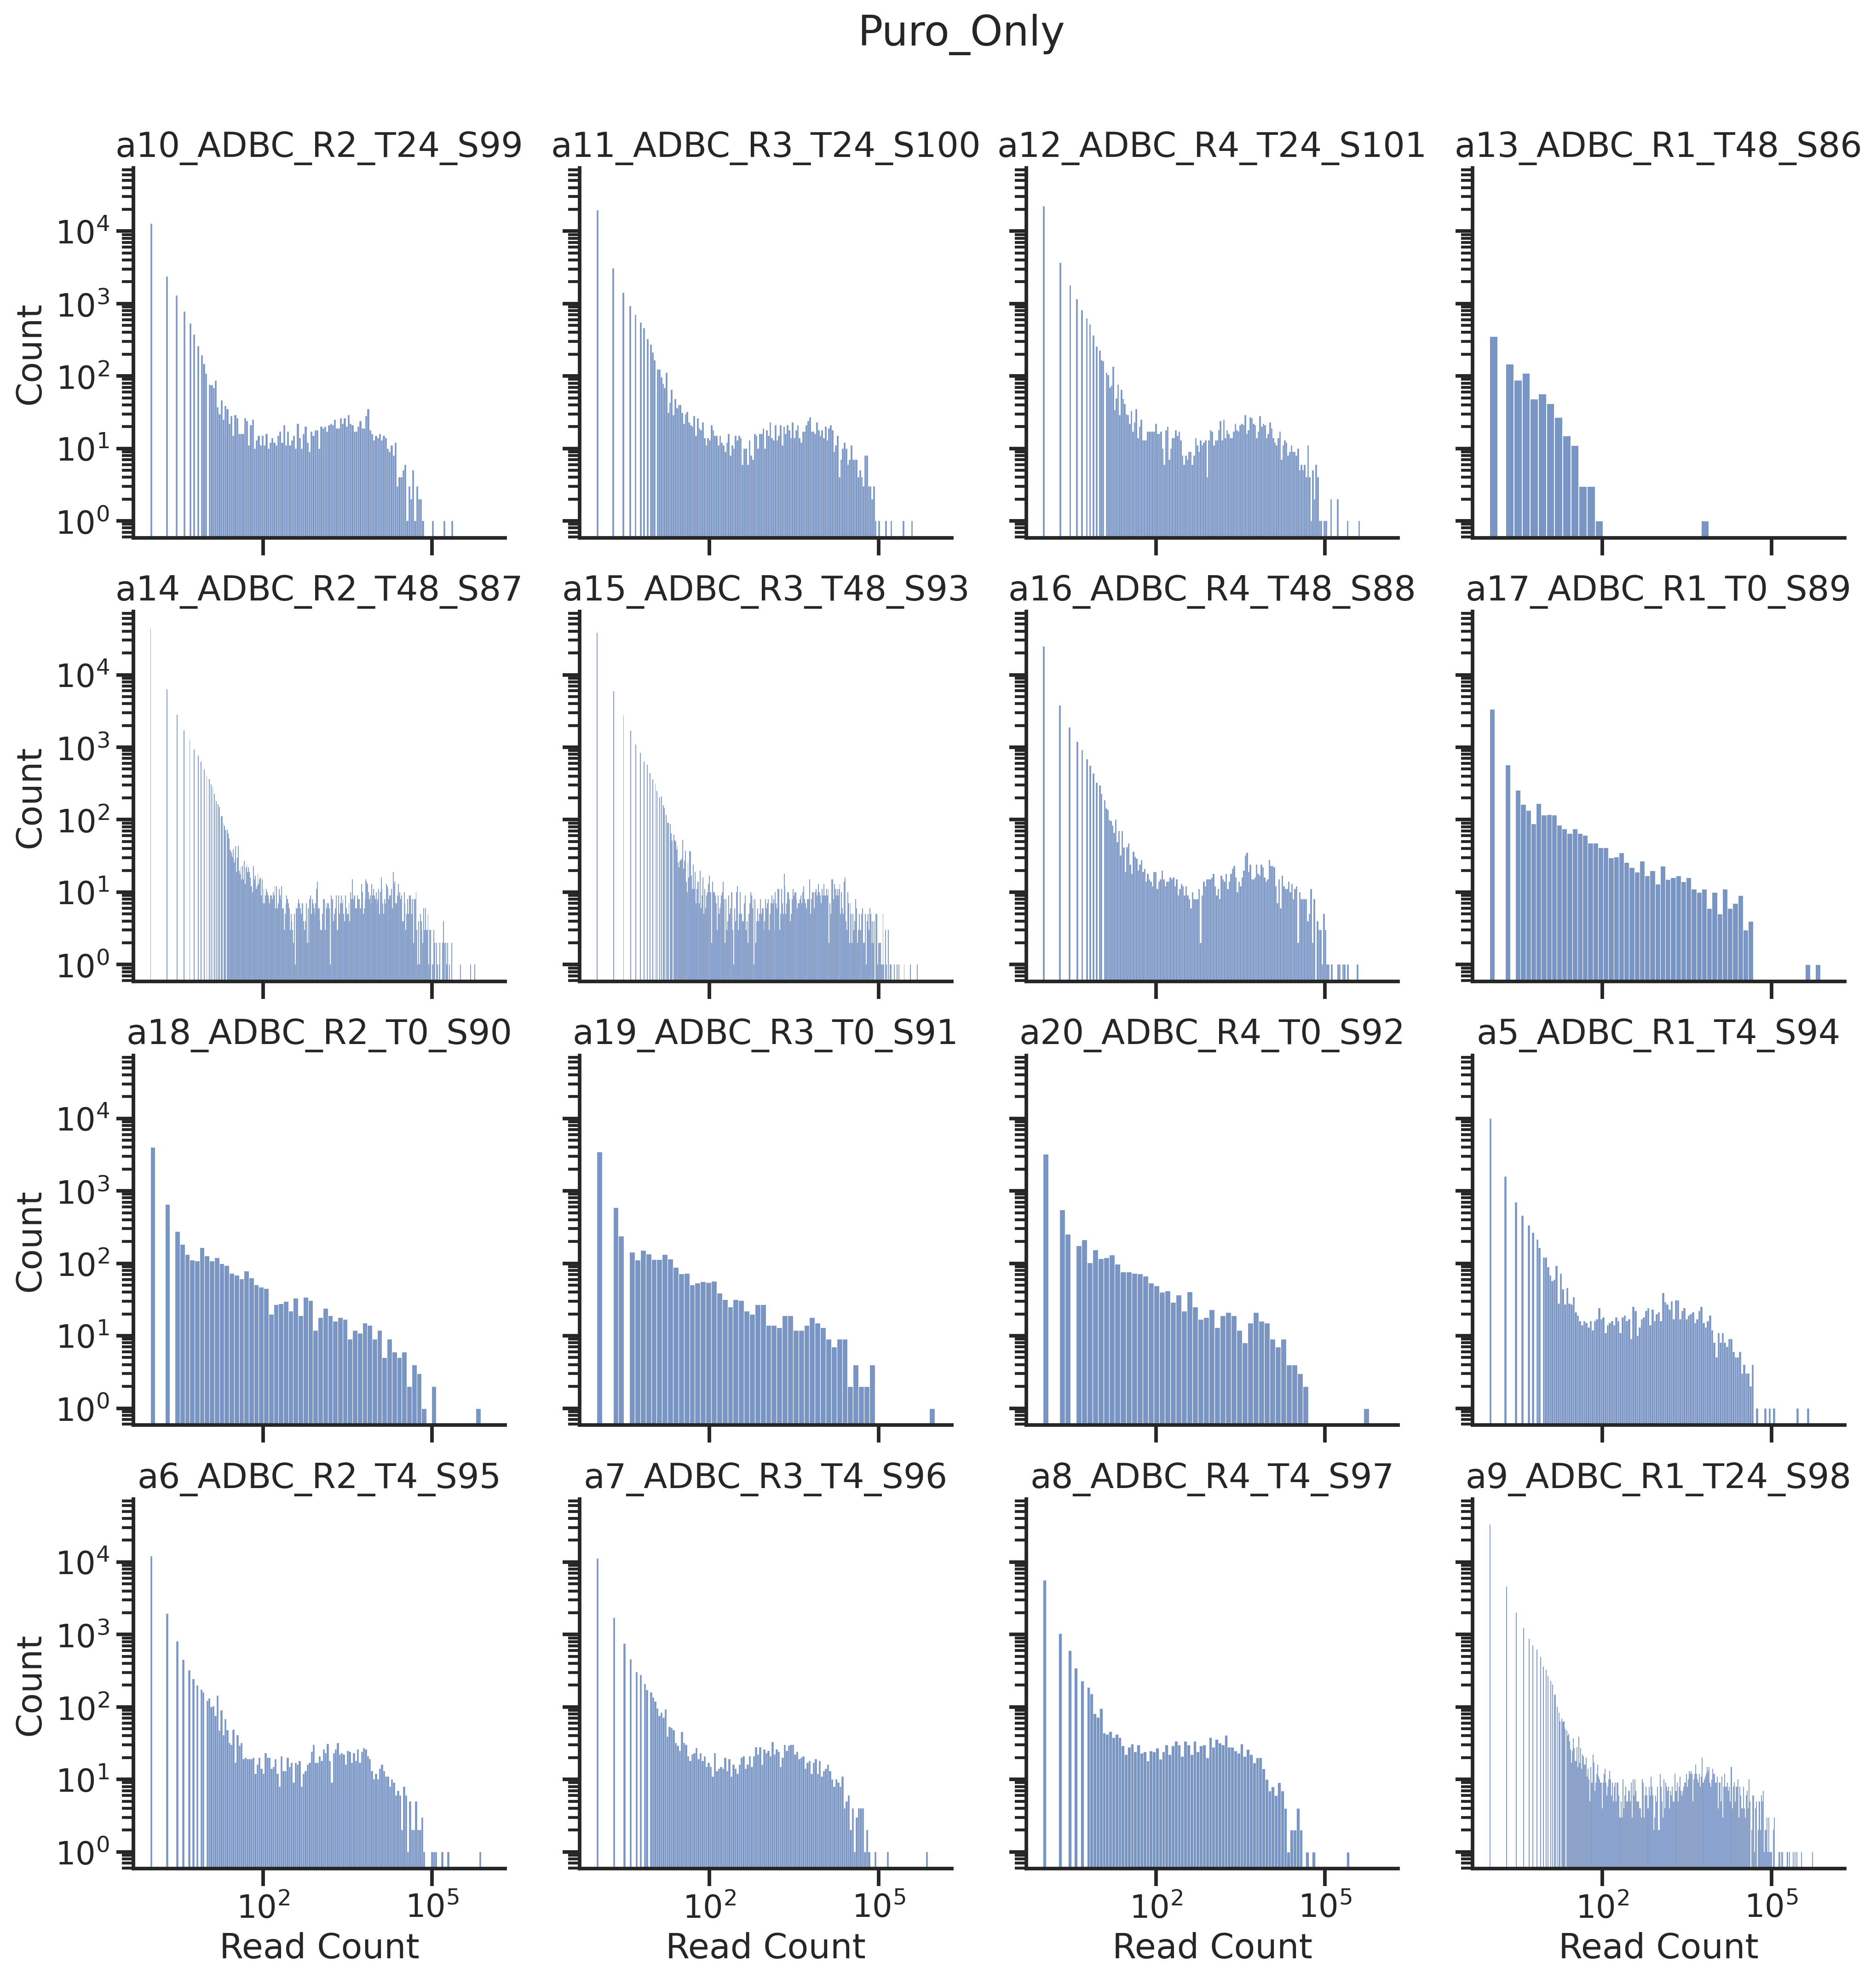

In [44]:
sns.set_style('ticks')

fig, axs = plt.subplots(4,4, sharex = True, sharey = True, figsize = (16,16), dpi = 300)
axs = axs.flatten()


def plot_one(i):
    # Table name
    table_name = grouped_ADBC_tables[i]
    # Read into a pandas DataFrame
    df = con.execute(f"SELECT * FROM {table_name}").df()

    ax = axs[i]
    ax = plotting.plot_reads_histogram(df, ax = ax)
    ax.set_title(re.search(r'umi_(.*S\d+)', table_name).group(1).replace("_Puro_Only", ""))

for i in range(len(grouped_ADBC_tables)):
    plot_one(i)


fig.suptitle("Puro_Only", y = 0.95)

In [47]:
grouped_RTBC_tables = [g for g in grouped_tables if "RTBC" in g]
grouped_RTBC_tables

['umi_r10_RTBC_Puro_Only_R2_T24_S107_RTBC_grouped',
 'umi_r11_RTBC_Puro_Only_R3_T24_S108_RTBC_grouped',
 'umi_r12_RTBC_Puro_Only_R4_T24_S109_RTBC_grouped',
 'umi_r13_RTBC_Puro_Only_R1_T48_S110_RTBC_grouped',
 'umi_r14_RTBC_Puro_Only_R2_T48_S111_RTBC_grouped',
 'umi_r15_RTBC_Puro_Only_R3_T48_S112_RTBC_grouped',
 'umi_r16_RTBC_Puro_Only_R4_T48_S113_RTBC_grouped',
 'umi_r17_RTBC_Puro_Only_R1_T0_S114_RTBC_grouped',
 'umi_r18_RTBC_Puro_Only_R2_T0_S115_RTBC_grouped',
 'umi_r19_RTBC_Puro_Only_R3_T0_S116_RTBC_grouped',
 'umi_r20_RTBC_Puro_Only_R4_T0_S117_RTBC_grouped',
 'umi_r5_RTBC_Puro_Only_R1_T4_S102_RTBC_grouped',
 'umi_r6_RTBC_Puro_Only_R2_T4_S103_RTBC_grouped',
 'umi_r7_RTBC_Puro_Only_R3_T4_S104_RTBC_grouped',
 'umi_r8_RTBC_Puro_Only_R4_T4_S105_RTBC_grouped',
 'umi_r9_RTBC_Puro_Only_R1_T24_S106_RTBC_grouped']

Text(0.5, 0.95, 'Puro_Only')

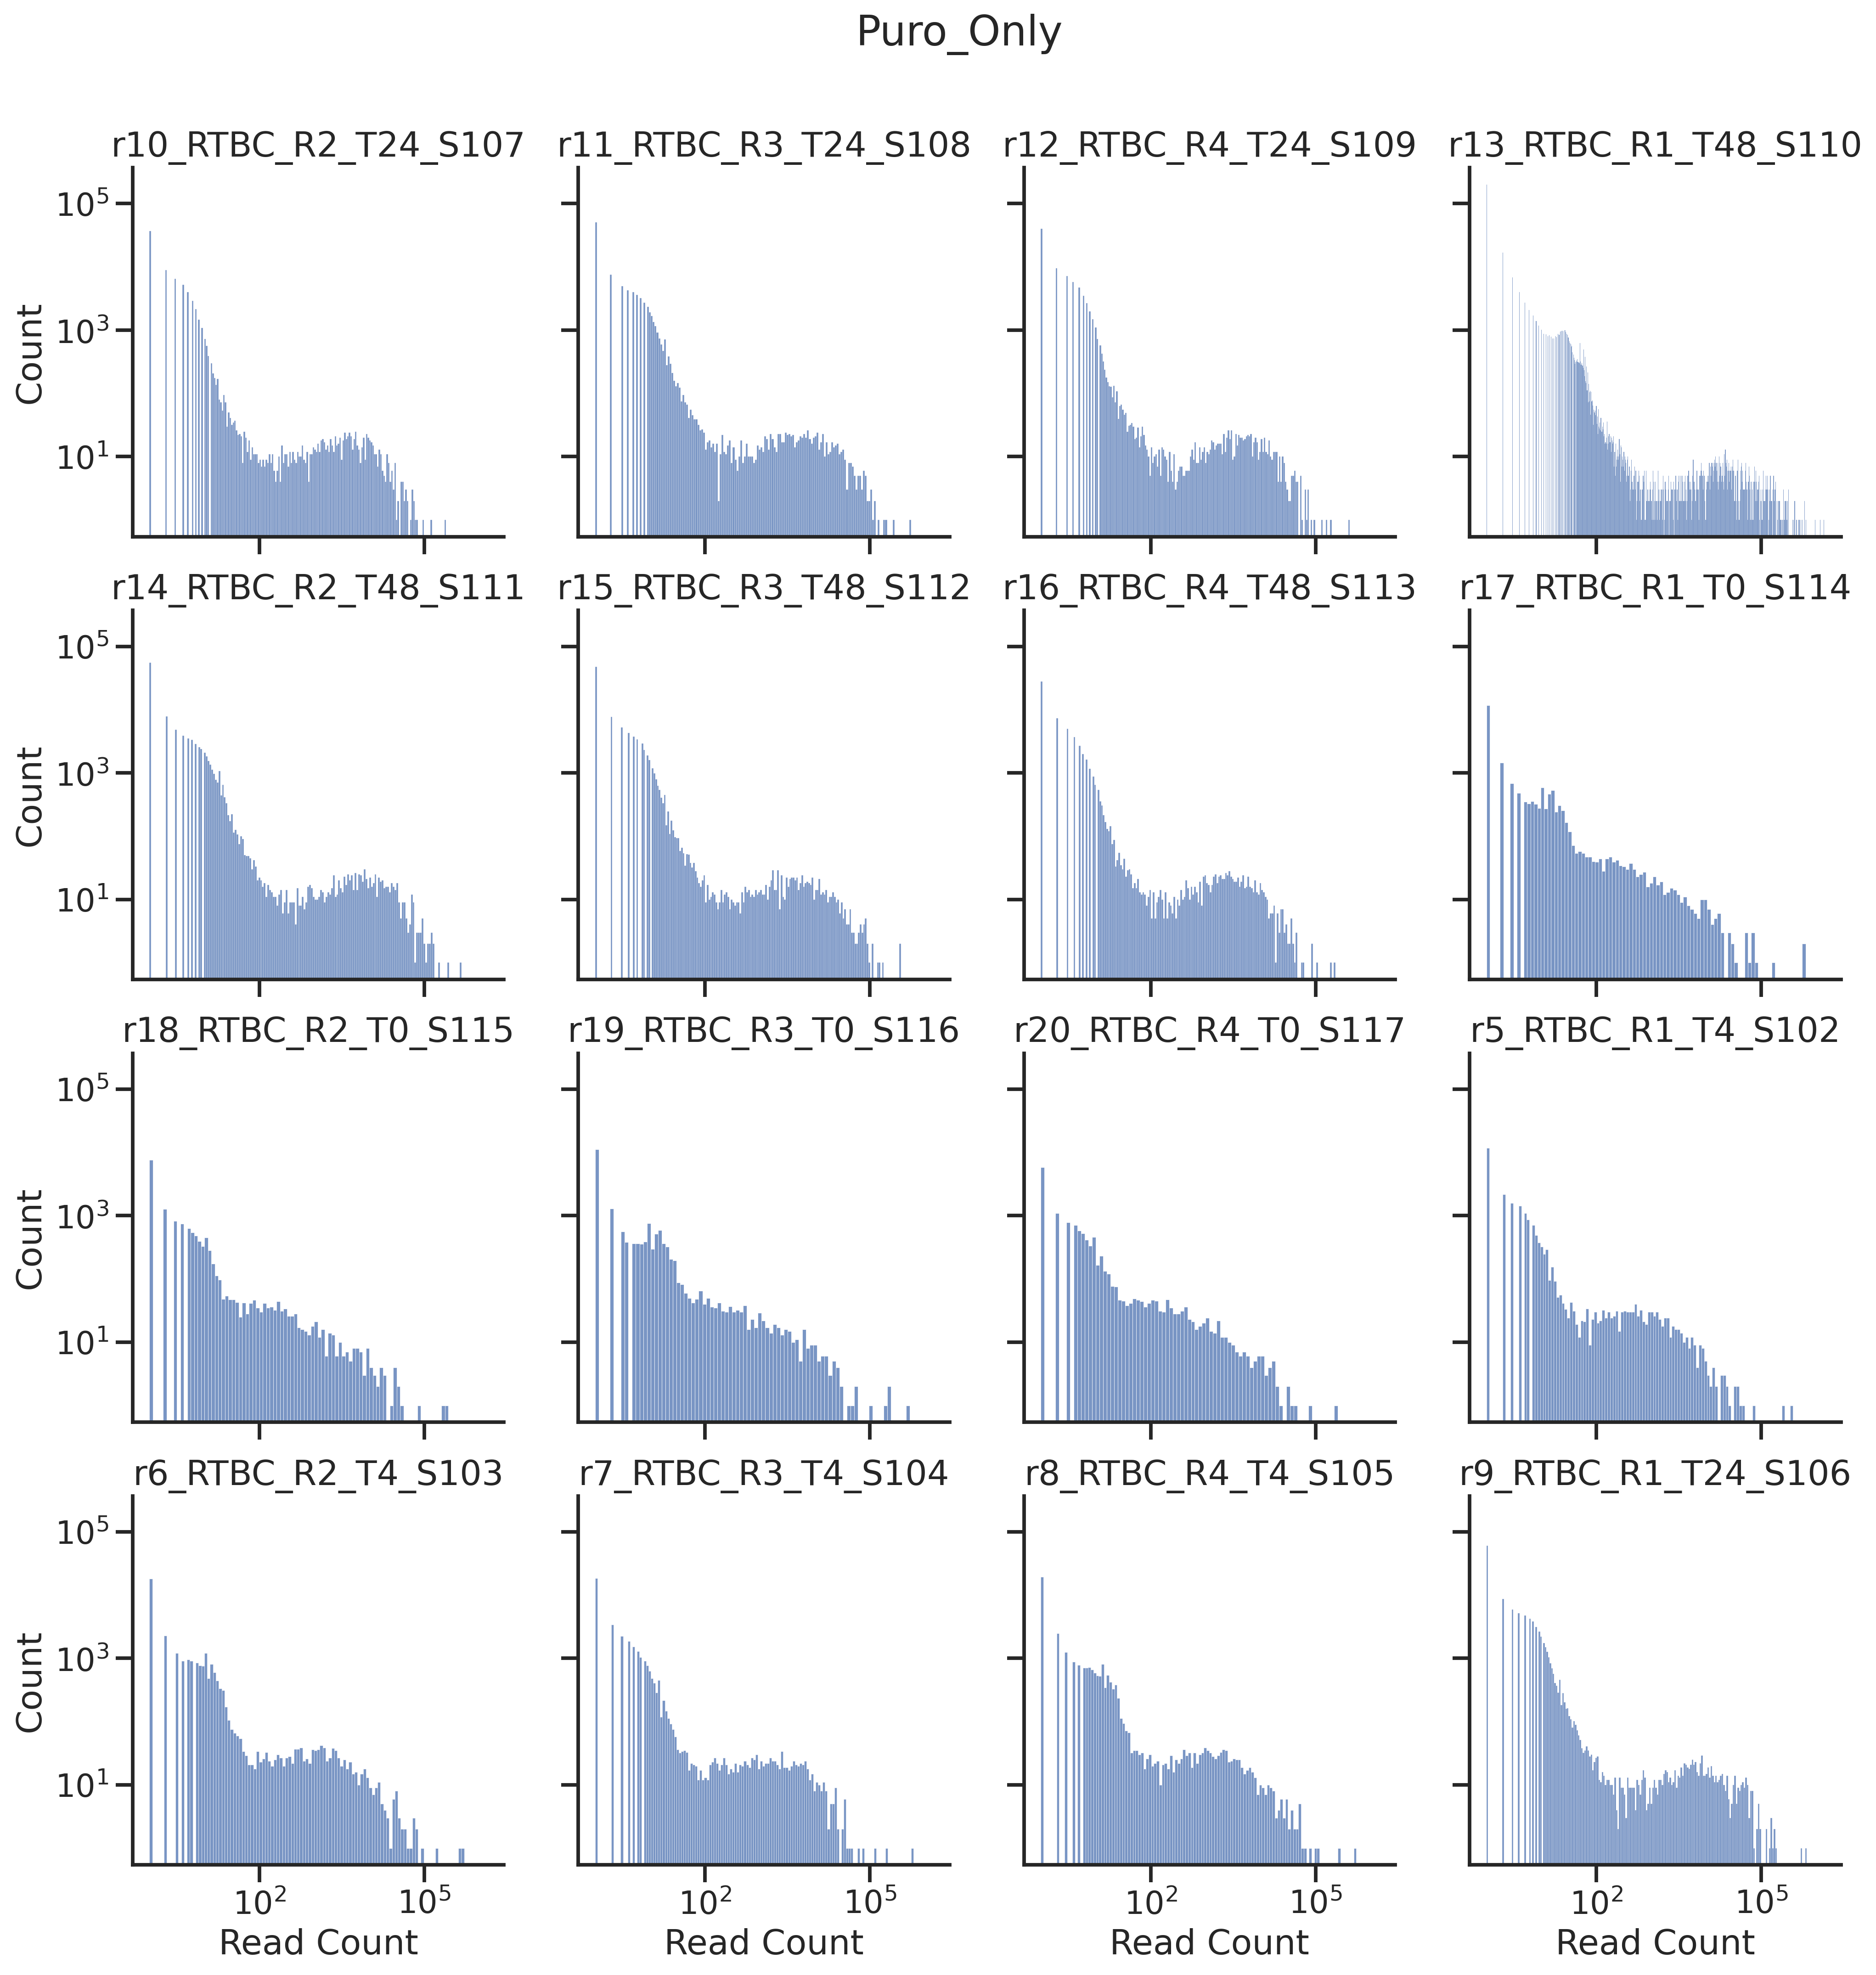

In [48]:
sns.set_style('ticks')

fig, axs = plt.subplots(4,4, sharex = True, sharey = True, figsize = (16,16), dpi = 300)
axs = axs.flatten()

def plot_one(i):
    # Table name
    table_name = grouped_RTBC_tables[i]
    # Read into a pandas DataFrame
    df = con.execute(f"SELECT * FROM {table_name}").df()

    ax = axs[i]
    ax = plotting.plot_reads_histogram(df, ax = ax)
    ax.set_title(re.search(r'umi_(.*S\d+)', table_name).group(1).replace("_Puro_Only", ""))

for i in range(len(grouped_RTBC_tables)):
    plot_one(i)


fig.suptitle("Puro_Only", y = 0.95)

# 2. Rim

In [ ]:
! cp "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/rim_NKX2-2_CC_UMI_whitelisted_concat_custom_threshold_redone.db"

In [ ]:
db_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/rim_NKX2-2_CC_UMI_whitelisted_concat_custom_threshold_redone.db"
db_path